# A/B-тесты

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Сбор-данных" data-toc-modified-id="Сбор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Сбор данных</a></span></li><li><span><a href="#Графики" data-toc-modified-id="Графики-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Графики</a></span></li><li><span><a href="#Анализ-всплесков-и-выбросов" data-toc-modified-id="Анализ-всплесков-и-выбросов-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ всплесков и выбросов</a></span></li></ul></div>

## Сбор данных

In [1]:
import pandas as pd
import datetime as dt
import numpy as np

BASE_URL = 'https://code.s3.yandex.net/datasets/'

orders = pd.read_csv(BASE_URL + 'orders_for_anomalies_detection.csv', sep=',')
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

visitors = pd.read_csv(BASE_URL + 
    'orders_for_anomalies_detection_visitors.csv', sep=','
)
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%d/%m/%Y')
)

print(orders.head())
print(visitors.head())

   orderId group                userId  revenue       date
0        1     A   4765212904118882304     7503 2019-04-01
1        2     A  14477413223818084352    11424 2019-04-01
2        3     B  10223965268965748736     1299 2019-04-01
3        4     A   1399771946645095424      999 2019-04-01
4        5     A  13269081434837460992      499 2019-04-01
        date group  visitors
0 2019-04-01     A       455
1 2019-04-02     A       501
2 2019-04-03     A      1313
3 2019-04-04     A       555
4 2019-04-05     A       564


In [2]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()
datesGroups.head()

,date,group
0,2019-04-01,A
2,2019-04-01,B
9,2019-04-02,A
10,2019-04-02,B
19,2019-04-03,B


In [3]:
# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(orders['date'] <= x['date'],
                       orders['group'] == x['group'])
    ].agg({'date' : 'max',
           'group' : 'max',
           'orderId' : 'nunique',
           'userId' : 'nunique',
           'revenue' : 'sum'}),
    axis=1
).sort_values(by=['date','group'])

print(ordersAggregated.head())

         date group  orderId  userId  revenue
0  2019-04-01     A        6       6   128276
2  2019-04-01     B        3       3     4082
9  2019-04-02     A       12      12   157683
10 2019-04-02     B        7       6   136535
20 2019-04-03     A       23      20   199868


In [4]:
# получаем агрегированные кумулятивные по дням данные
# о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(visitors['date'] <= x['date'],
                       visitors['group'] == x['group'])
    ].agg({'date' : 'max',
           'group' : 'max',
           'visitors' : 'sum'}),
    axis=1
).sort_values(by=['date','group'])

print(visitorsAggregated.head())

         date group  visitors
0  2019-04-01     A       455
2  2019-04-01     B       464
9  2019-04-02     A       956
10 2019-04-02     B       977
20 2019-04-03     A      2269


In [5]:
# объединяем кумулятивные данные в одной таблице
# и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(
    visitorsAggregated,
    on=['date', 'group'],
    how='outer',
)
cumulativeData.columns = ['date', 'group', 'orders', 'buyers',
                          'revenue', 'visitors']

print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-04-01     A       6       6   128276       455
1 2019-04-01     B       3       3     4082       464
2 2019-04-02     A      12      12   157683       956
3 2019-04-02     B       7       6   136535       977
4 2019-04-03     A      23      20   199868      2269


## Графики

In [6]:
import matplotlib.pyplot as plt

# датафрейм с кумулятивным количеством заказов
# и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[
    cumulativeData['group']=='A'
][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов
# и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[
    cumulativeData['group']=='B'
][['date','revenue', 'orders']]

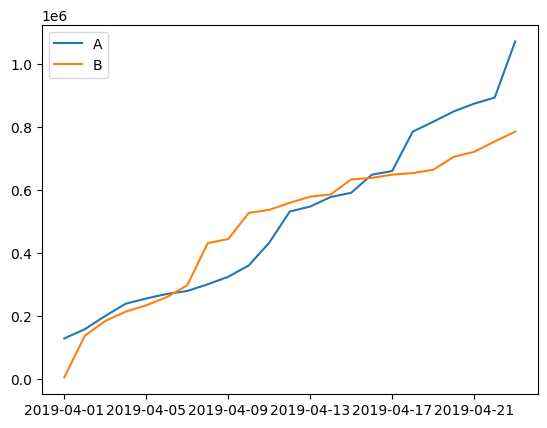

In [7]:
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'],
         cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'],
         cumulativeRevenueB['revenue'], label='B')

plt.legend()
plt.show()

Выручка почти равномерно увеличивается в течение всего теста. Хороший знак.

Однако графики выручки обеих групп в нескольких точках резко растут. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. Такие выбросы проанализируем в следующем уроке.

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:

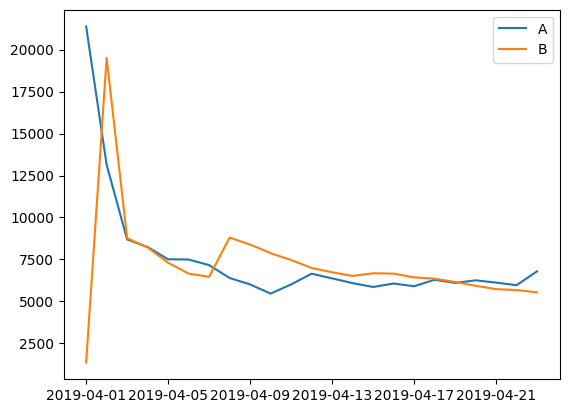

In [8]:
plt.plot(cumulativeRevenueA['date'],
         cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'],
         label='A')
plt.plot(cumulativeRevenueB['date'],
         cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'],
         label='B')
plt.legend()
plt.show()

Средний чек тоже становится равномерным ближе к концу теста: установился для группы A и продолжает падать для группы B. Возможно, в группу B в первой половине теста попали крупные заказы (резкий всплеск на графике). Тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.

Построим график относительного различия для среднего чека. Добавим горизонтальную ось методом axhline() (от англ. horizontal line across the axis*, «горизонтальная линия поперек оси»):

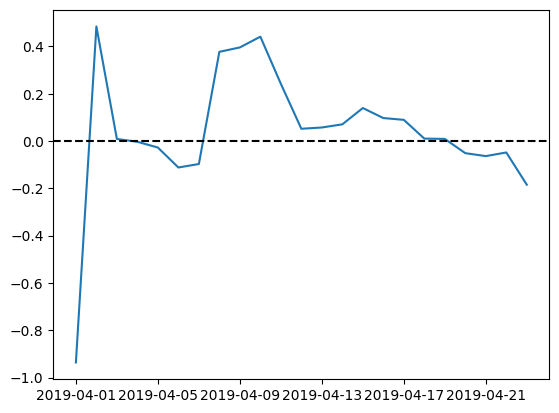

In [9]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB,
    left_on='date',
    right_on='date',
    how='left',
    suffixes=['A', 'B'],
)

# cтроим отношение средних чеков
plt.plot(
    mergedCumulativeRevenue['date'],
    (mergedCumulativeRevenue['revenueB']
     / mergedCumulativeRevenue['ordersB'])
     / (mergedCumulativeRevenue['revenueA']
        / mergedCumulativeRevenue['ordersA'])
     - 1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.show()

В нескольких точках график различия между сегментами резко «скачет». Где-то уж точно спрятались крупные заказы и выбросы! Найдём их позже.

Аналогично проанализируем график кумулятивной конверсии. Зададим масштаб осей методом `plt.axis()`. Передадим ему минимальное и максимальное значения оси `x`; минимальное и максимальное значения оси `y` — `["2019-04-01", '2019-04-23', 0, 0.015]`:

Внимание, тут "конверсия" - это просто количество заказов в пересчёте на количество визитов.

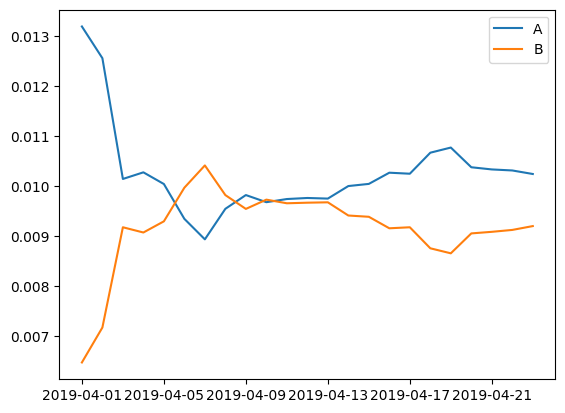

In [10]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# задаем масштаб осей
#plt.axis(['2019-04-01', '2019-04-23', 0, 0.015])
plt.show()

Симметричный график получился! Группы колебались около одного значения, но затем конверсия группы A вырвалась вперёд и зафиксировалась, а конверсия группы B просела и также зафиксировалась.

Построим график относительного различия кумулятивных конверсий:

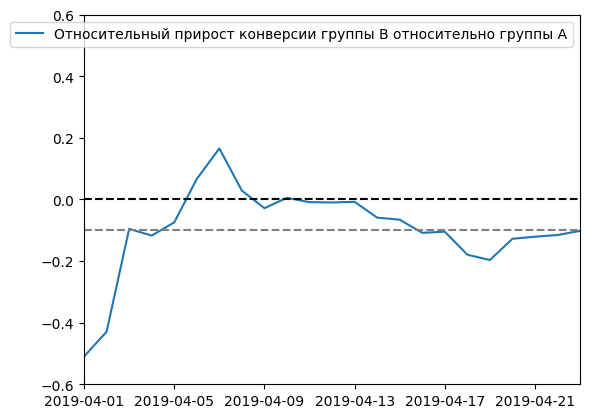

In [11]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(
    mergedCumulativeConversions['date'],
    mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1,
    label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axis([dt.date(2019, 4, 1), dt.date(2019, 4, 23), -0.6, 0.6])
plt.show()

В начале теста группа B значительно проигрывала группе A, затем вырвалась вперёд. Потом её конверсия снова падала, но теперь постепенно растёт.

В целом отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя. Впрочем, сперва стоит проанализировать аномалии, возможно, они изменят картину. Сделаем это в следующем уроке.

## Анализ всплесков и выбросов

In [12]:
import pandas as pd
import datetime as dt

data = pd.read_csv(BASE_URL + 'orders_for_anomalies_detection.csv', sep=',')
data['date'] = data['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

print(data.head(10))

   orderId group                userId  revenue       date
0        1     A   4765212904118882304     7503 2019-04-01
1        2     A  14477413223818084352    11424 2019-04-01
2        3     B  10223965268965748736     1299 2019-04-01
3        4     A   1399771946645095424      999 2019-04-01
4        5     A  13269081434837460992      499 2019-04-01
5        6     B   7141419942738429952      482 2019-04-01
6        7     A  14179588155630520320     2999 2019-04-01
7        8     A   1225733206606480128   104852 2019-04-01
8        9     B   3362287473339592192     2301 2019-04-01
9       10     A  11670724616393357312      499 2019-04-02


Есть существенный разлёт значений. 4 из 10 - менее 1 тыс руб, 1 из 10 - более 100 тыс руб. Проанализируем распределение с помощью гистограмм.

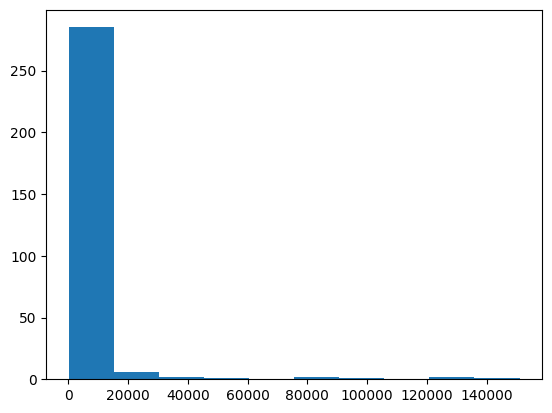

In [13]:
plt.hist(data['revenue'])
plt.show()

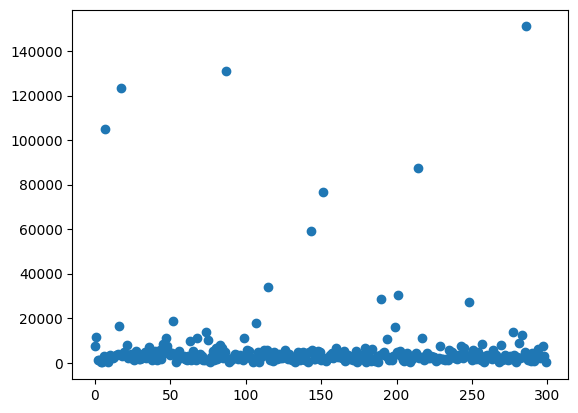

In [14]:
x_values = pd.Series(range(0, len(data['revenue'])))
plt.scatter(x_values, data['revenue'])
plt.show()

Дорогие заказы стоят отдельными точками.

Обычно от 1 до 5% крайних значений - выбрасывают.

Считаем, какие значения укладываются в 90, 95 и 99 перцентили.

In [15]:
print(np.percentile(data['revenue'], [90, 95, 99]))

[  8113.8   13817.   105038.04]


Подсчитаем количество заказов по пользователям и посмотрим на результат:

In [16]:
import pandas as pd
import datetime as dt

data = pd.read_csv(BASE_URL + 'orders_for_anomalies_detection.csv', sep=',')
data['date'] = data['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

ordersByUsers = (
    data.groupby('userId', as_index=False)
    .agg({'orderId': 'nunique'})
)

ordersByUsers.columns = ['userId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

                   userId  orders
103  10915146588096065536      15
171  17524390106492114944      10
26    2181679483747416832       8
13    1072811847256720512       7
126  12759566205054128128       6
148  14477413223818084352       6
28    2332073096806479360       6
20    1577273240726417664       5
41    3362287473339592192       5
11     923223027330505600       5


Оценим распределение пользователей по количеству сделанных заказов.

(array([158.,   9.,  10.,   3.,   1.,   1.,   1.,   0.,   0.,   1.]),
 array([ 1. ,  2.4,  3.8,  5.2,  6.6,  8. ,  9.4, 10.8, 12.2, 13.6, 15. ]),
 <BarContainer object of 10 artists>)

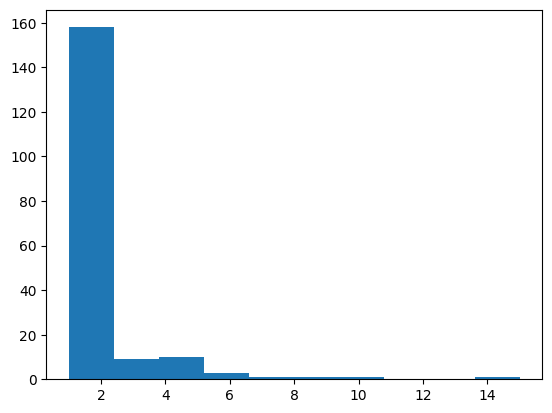

In [17]:
import matplotlib.pyplot as plt 
plt.hist(ordersByUsers['orders'])

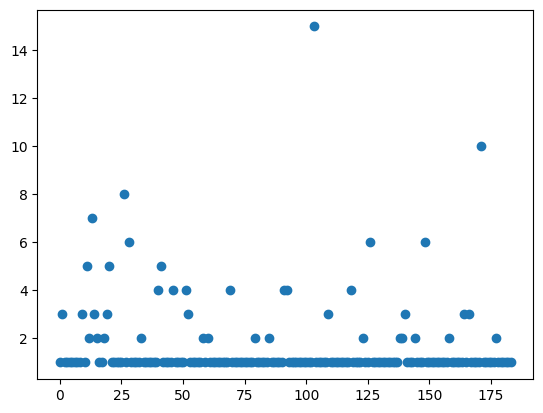

In [18]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])

Ну, больше одного мало кто заказал. Непонятно, считать ли тех, у кого по 2-4 заказа, особенными, аномальными.

In [19]:
import numpy as np
print(np.percentile(ordersByUsers['orders'], [90, 95, 99]))

[3.   4.85 8.34]


Не более 5% пользователей оформляли больше чем 4.85 (т. е. 5) заказов. И 10% пользователей заказывали более трёх раз.

Разумным станет оставить только тех, кто ниже 95-го перцентиля в обоих случаях.